### TCGA to CCLE mutation prediction: LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_to_ccle'
)

# 'aupr' or 'auroc'
metric = 'aupr'

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.drop(columns=['cancer_type'], inplace=True)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)

print(nz_coefs_df.shape)
print(nz_coefs_df.gene.unique())
nz_coefs_df.head()

(8160, 5)
['TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'NPM1' 'PBRM1'
 'MET' 'CDKN2A' 'NCOR1' 'FLT3' 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2'
 'BCOR' 'NRAS' 'ERBB2' 'ARID1A' 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A'
 'STK11' 'NOTCH1' 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2'
 'IDH1' 'EP300' 'ATRX' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8'
 'GNAQ' 'KRAS' 'JAK2' 'EZH2']


,gene,lasso_param,seed,fold,nz_coefs
0,TP53,500.0,1,0,15904
1,TP53,500.0,1,1,15909
2,TP53,500.0,1,2,15925
3,TP53,500.0,1,3,15903
4,TP53,750.0,1,0,15951


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, 'tcga_to_ccle')
perf_df.drop(columns=['holdout_cancer_type'], inplace=True)
perf_df.lasso_param = perf_df.lasso_param.astype(float)

print(perf_df.shape)
print(perf_df.gene.unique())
perf_df.head()

(24480, 9)
['TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'NPM1' 'PBRM1'
 'MET' 'CDKN2A' 'NCOR1' 'FLT3' 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2'
 'BCOR' 'NRAS' 'ERBB2' 'ARID1A' 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A'
 'STK11' 'NOTCH1' 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'IDH2'
 'IDH1' 'EP300' 'ATRX' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1' 'ABL1'
 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1' 'CDH1'
 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8'
 'GNAQ' 'KRAS' 'JAK2' 'EZH2']


,auroc,aupr,gene,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.00000,TP53,signal,42,train,0,tcga_to_ccle,500.0
1,0.86433,0.92399,TP53,signal,42,test,0,tcga_to_ccle,500.0
2,0.90009,0.85243,TP53,signal,42,cv,0,tcga_to_ccle,500.0
3,1.00000,1.00000,TP53,signal,42,train,1,tcga_to_ccle,500.0
4,0.84829,0.91505,TP53,signal,42,test,1,tcga_to_ccle,500.0


### Compare feature selection with performance

In [5]:
coefs_perf_df = (nz_coefs_df
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal', 'experiment'])
)

print(coefs_perf_df.shape)
coefs_perf_df.head()

(24480, 8)


,gene,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
0,TP53,500.0,1,0,15904,1.00000,1.00000,train
1,TP53,500.0,1,0,15904,0.86023,0.91598,test
2,TP53,500.0,1,0,15904,0.91403,0.89172,cv
3,TP53,500.0,1,1,15909,1.00000,1.00000,train
4,TP53,500.0,1,1,15909,0.85615,0.90908,test


Text(0.5, 0, 'Number of nonzero features')

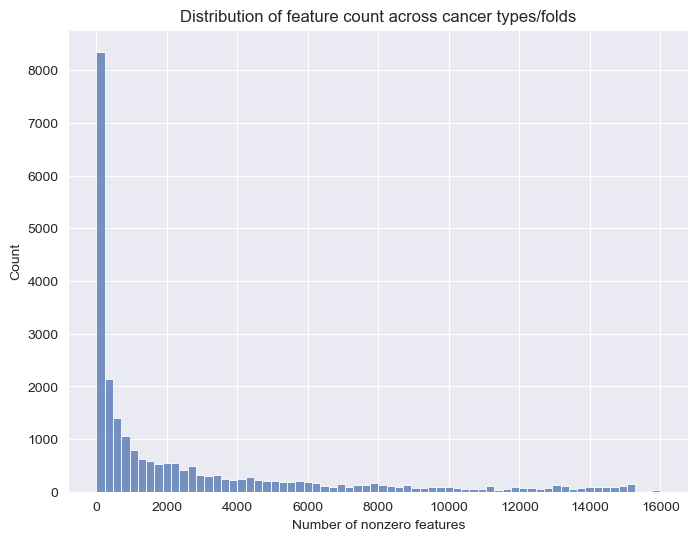

In [6]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_perf_df.nz_coefs)
plt.title('Distribution of feature count across cancer types/folds')
plt.xlabel('Number of nonzero features')

### Get "best" LASSO parameters and compare performance across all genes

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll do this for each gene/cancer type in the dataset below, and plot the distribution of differences between the two strategies, as a way to quantify which strategy is "better" for generalization across cancer types.

In [7]:
def get_top_and_smallest_diff(gene):
    top_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    top_5_lasso = top_df.loc[top_df.aupr_rank <= 5, :].index
    
    # get parameter with best validation performance
    top_lasso_param = top_5_lasso[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.gene == gene) & 
                    (nz_coefs_df.lasso_param.isin(top_5_lasso))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    holdout_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'test') &
                (perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    
    top_smallest_diff = (
        holdout_df.loc[top_lasso_param, 'mean_aupr'] -
        holdout_df.loc[smallest_lasso_param, 'mean_aupr']
    )
    return [gene, top_lasso_param, smallest_lasso_param, top_smallest_diff]

print(get_top_and_smallest_diff('SETD2'))

['SETD2', 5.0, 0.1, 0.030128749999999982]


In [8]:
all_top_smallest_diff_df = []

for gene in perf_df.gene.unique():
    all_top_smallest_diff_df.append(get_top_and_smallest_diff(gene))
        
all_top_smallest_diff_df = pd.DataFrame(
    all_top_smallest_diff_df,
    columns=['gene', 'top_lasso_param',
             'smallest_lasso_param', 'top_smallest_diff']
)

all_top_smallest_diff_df.head()

,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff
0,TP53,0.05,0.01,0.005441
1,KDM5C,10.00,0.05,0.030332
2,RB1,0.05,0.01,0.015531
3,CIC,0.05,0.01,-0.001245
4,BRAF,0.10,0.05,0.014049


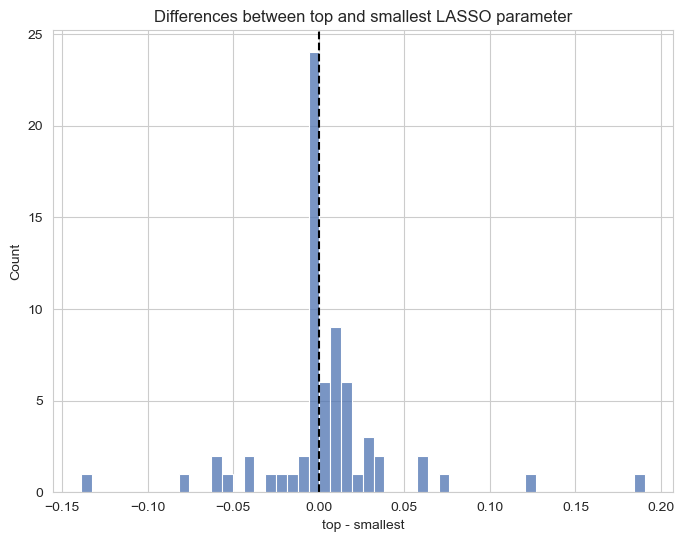

In [9]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(all_top_smallest_diff_df.top_smallest_diff)
plt.title('Differences between top and smallest LASSO parameter')
plt.xlabel('top - smallest')
plt.gca().axvline(0, color='black', linestyle='--')

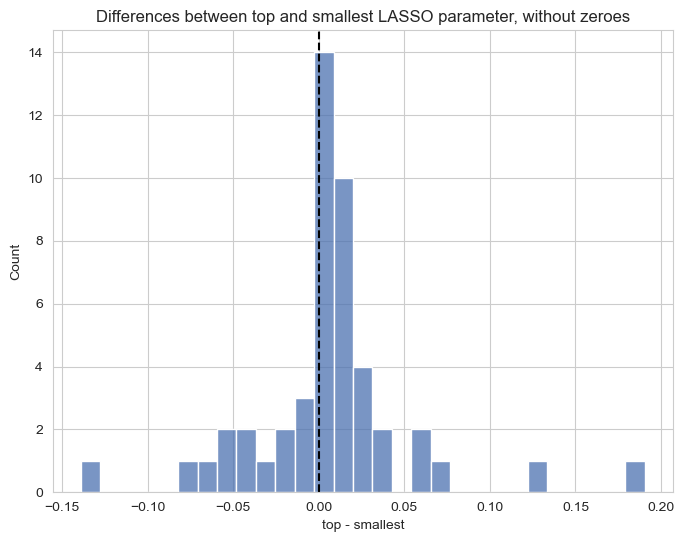

In [10]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(
    all_top_smallest_diff_df[all_top_smallest_diff_df.top_smallest_diff != 0.0].top_smallest_diff
)
plt.title('Differences between top and smallest LASSO parameter, without zeroes')
plt.xlabel('top - smallest')
plt.gca().axvline(0, color='black', linestyle='--')

In [11]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=False).head(10)

,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff
16,SMARCA4,10.00,0.010,0.190400
42,CTNNB1,5.00,0.100,0.123941
6,ARID2,10.00,0.500,0.072183
43,PTEN,0.05,0.010,0.060656
59,NF1,0.01,0.005,0.060571
63,CASP8,5.00,0.100,0.036621
5,JAK1,1.00,0.050,0.032962
1,KDM5C,10.00,0.050,0.030332
62,SETD2,5.00,0.100,0.030129
53,ASXL1,5.00,0.500,0.026842


In [12]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=True).head(10)

,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff
60,NFE2L2,0.05,0.010,-0.139007
10,MET,0.01,0.005,-0.078025
46,PIK3CA,0.05,0.005,-0.059924
55,BAP1,0.10,0.050,-0.059283
36,IDH2,5.00,0.050,-0.051470
17,FOXL2,0.05,0.010,-0.040049
31,ARID1B,500.00,0.010,-0.038149
47,NOTCH2,250.00,5.000,-0.025544
11,CDKN2A,0.05,0.010,-0.024705
9,PBRM1,10.00,1.000,-0.014879


### Which genes/mutations are "hard to predict"

We want to identify genes for which:

* We can't predict mutation status at all ("cv" performance is poor)
* We can predict mutation status well within TCGA, but we can't transfer our predictions to CCLE ("cv" performance is decent/good and "test" performance is poor)

For now, we'll just take the "best" model (by validation performance) for these analyses, we could do it with the "smallest" model too but the results will probably be similar.

In [13]:
cv_perf_df = (
    perf_df[(perf_df.data_type == 'cv') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'data_type', 'signal'])
).copy()
cv_perf_df.lasso_param = cv_perf_df.lasso_param.astype(float)

print(cv_perf_df.shape)
cv_perf_df.head()

(8160, 6)


,auroc,aupr,gene,seed,fold,lasso_param
2,0.90009,0.85243,TP53,42,0,500.0
5,0.89023,0.83244,TP53,42,1,500.0
8,0.89121,0.83449,TP53,42,2,500.0
11,0.90522,0.86211,TP53,42,3,500.0
2,0.90792,0.87181,TP53,42,0,1.0


In [14]:
test_perf_df = (
    perf_df[(perf_df.data_type == 'test') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'data_type', 'signal'])
).copy()
test_perf_df.lasso_param = test_perf_df.lasso_param.astype(float)

print(test_perf_df.shape)
test_perf_df.head()

(8160, 6)


,auroc,aupr,gene,seed,fold,lasso_param
1,0.86433,0.92399,TP53,42,0,500.0
4,0.84829,0.91505,TP53,42,1,500.0
7,0.81562,0.87702,TP53,42,2,500.0
10,0.83514,0.89637,TP53,42,3,500.0
1,0.88000,0.92684,TP53,42,0,1.0


In [15]:
best_perf_df = (
    all_top_smallest_diff_df.loc[:, ['gene', 'top_lasso_param']]
      .merge(cv_perf_df,
             left_on=['gene', 'top_lasso_param'],
             right_on=['gene', 'lasso_param'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'cv_auroc',
                       'aupr': 'cv_aupr'})
      .merge(test_perf_df,
             left_on=['gene', 'top_lasso_param', 'seed', 'fold'],
             right_on=['gene', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'test_auroc',
                       'aupr': 'test_aupr'})
)
best_perf_df['cv_test_auroc_diff'] = (
    best_perf_df.cv_auroc - best_perf_df.test_auroc
)
best_perf_df['cv_test_aupr_diff'] = (
    best_perf_df.cv_aupr - best_perf_df.test_aupr
)

print(best_perf_df.shape)
best_perf_df.sort_values(by='cv_test_aupr_diff', ascending=False).head()

(544, 10)


,gene,top_lasso_param,cv_auroc,cv_aupr,seed,fold,test_auroc,test_aupr,cv_test_auroc_diff,cv_test_aupr_diff
296,IDH1,10.0,0.99150,0.99788,42,0,0.36782,0.15805,0.62368,0.83983
298,IDH1,10.0,0.98935,0.99706,42,2,0.38506,0.16053,0.60429,0.83653
301,IDH1,10.0,0.94053,0.97991,1,1,0.35057,0.14692,0.58996,0.83299
300,IDH1,10.0,0.96480,0.99082,1,0,0.37931,0.15969,0.58549,0.83113
302,IDH1,10.0,0.94038,0.97378,1,2,0.36782,0.15896,0.57256,0.81482


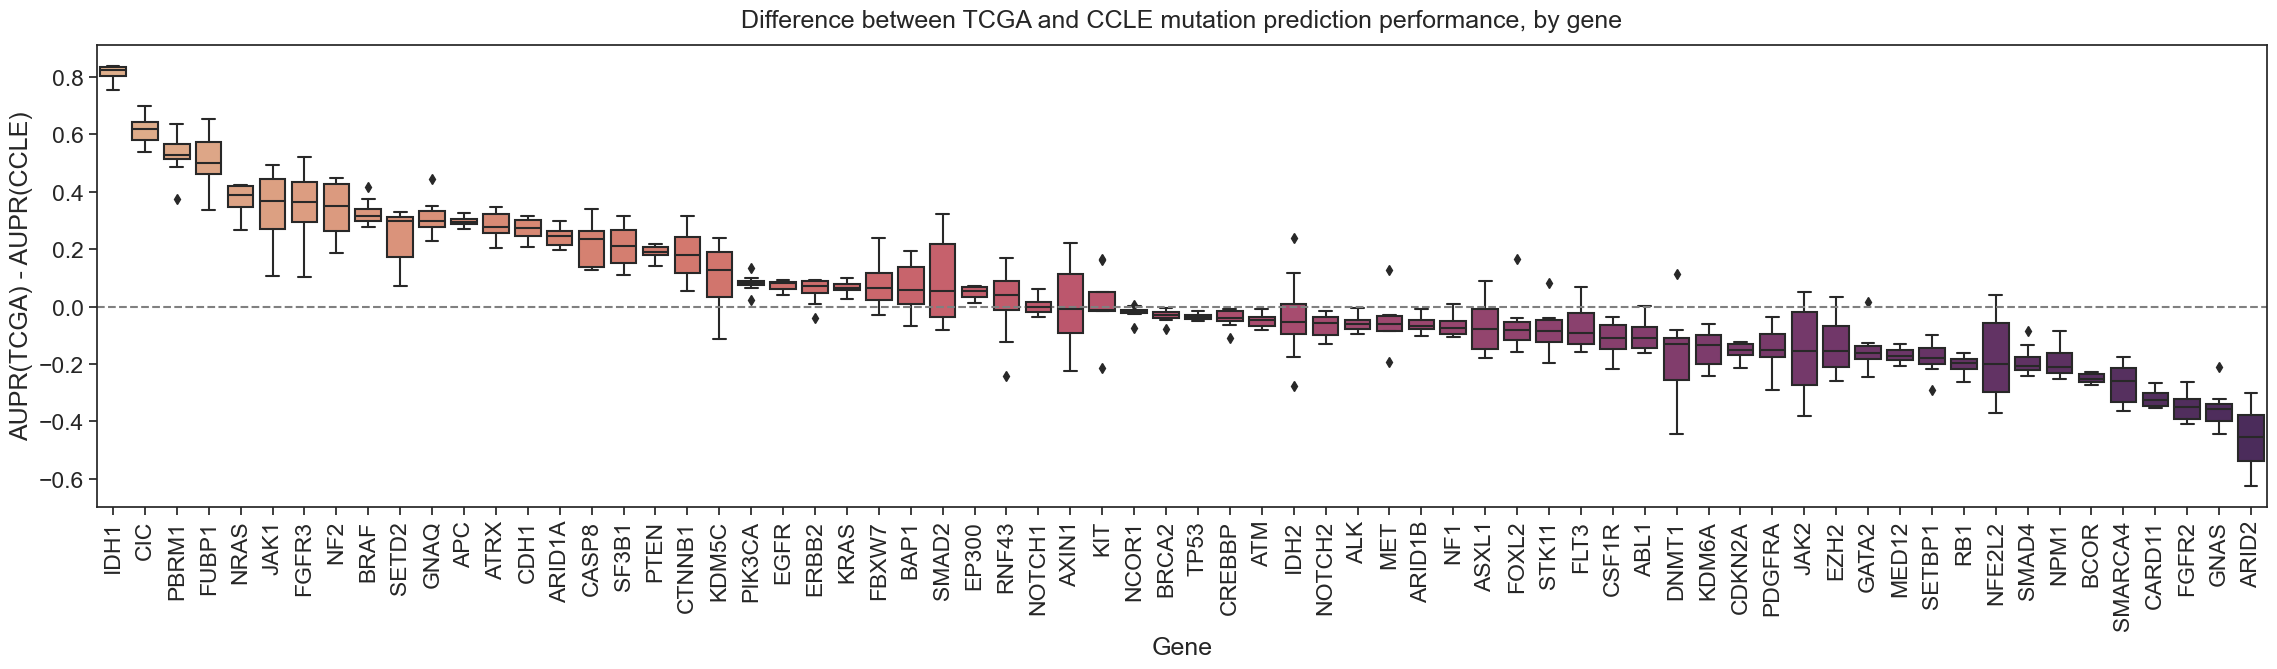

In [16]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (28, 6)})
sns.set_style('ticks')

# order boxes by median diff per gene
gene_order = (best_perf_df
    .groupby(['gene', 'top_lasso_param'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.5):
    ax = sns.boxplot(data=best_perf_df, order=gene_order,
                     x='gene', y='cv_test_aupr_diff',
                     palette='flare')
    ax.axhline(0.0, linestyle='--', color='grey')
    plt.xticks(rotation=90)
    plt.title(f'Difference between TCGA and CCLE mutation prediction performance, by gene', y=1.02)
    plt.xlabel('Gene')
    plt.ylabel('AUPR(TCGA) - AUPR(CCLE)')